This is an example about how assignment 3 can be done. The task is to download the data, extract the samples corresponding to two classes only (for example, the zeros and the ones, or the eights and the nines) and then, construct a CNN to classify them. Piece of cake.

The first step is to import the needed libraries.

Then, we download the data, that will be stored in two containers for training and test.  

In [ ]:
import numpy as np                                 # Numpy is always handy

import torch                                       # Import Pytorch
from torchvision import datasets                   # Here we find the images
from torch.utils.data import Dataset, Subset       # This is to deal with the datasets

import torch.nn as nn                              # Here we find the neural networks that we need
import torch.nn.functional as F                    # Here we find functions as the ReLU
import torch.optim as optim                        # The Adam optimizer is inside this library

import torchvision                                 # We will use this later to show some images
import torchvision.transforms as transforms        #
from torchvision.transforms import ToTensor        # We need to manually convert a variable to tensor
import matplotlib.pyplot as plt                    # To plot things

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

def convert(y):                                   # This is to redefine labels of
  classes=np.unique(y)                            # a set of binary class data as 0 and 1
  y[np.argwhere(y==classes[0])]=0
  y[np.argwhere(y==classes[1])]=1
  return y

100%|██████████| 9912422/9912422 [00:00<00:00, 84013230.20it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70264323.56it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30637892.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12708825.06it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



The next step is to construct subset of data belonging to only two arbitrary classes. The neural network will have a binary output.

In [ ]:
batch_size=100
classes=np.array([8,9])                           # These are the pair of classes that we want to extract. They do not need to be 0 and 1

y=train_data.targets                              # Here we extract all the labels
index=np.argwhere(y==classes[0])                  # We find the data labelled as  classes[0]
index=np.append(index,np.argwhere(y==classes[1])) # and then the ones labelled as classes[1]
train_subset=Subset(train_data,index)             # We use Subset to select the two classes
trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size,
    shuffle=True)                                 # We construct a trainloader with them
                                                  # and we shuffle them

y=test_data.targets                               # We do the same with the test data
index=np.argwhere(y==8)
index=np.append(index,np.argwhere(y==9))
test_subset=Subset(test_data,index)
testloader = torch.utils.data.DataLoader(
    test_subset, batch_size=64,
    shuffle=True)

Here we construct the CNN. We have to compute the dimension of each of the convolutional layers. The first one has an input of 28 $\times$ 28 and it has one channel, since the images are grayscale.

The output has a dimension equal to

$$
\left\lfloor\frac{M_I+p-M_w+s}{s}\right\rfloor\times
\left\lfloor\frac{N_I+p-N_w+s}{s}\right\rfloor
$$

where $\left\lfloor(\cdot)\right\rfloor$ symbolizes floor rounding.  $M_I, N_I$, $M_w, N_w$ are the dimensions of the input, $p$ is the padding and $s$ is the stride. In our example, we do not apply zero padding ($p=0$) and the stride is $s=1$. The images and the kernels are squared ($M = N$) and therefore the dimensions of the output are

$$
M_I-M_w+1
$$

The MaxPool, as it is defined below, takes the maximum of every adjacent patch of 2$\times$2 pixels, and the result is an image with half the number of pixels. The Maxpool ignores the last row and column of pixels if the dimensions are odd. Then, the dimensions after the MaxPool in this example are  

$$\left\lfloor \frac{M_I-M_w+1}{2}\right\rfloor$$


We choose kernels of dimension $3\times3$. Then, for the first convolution, the input is 28 $\times$ 28, and then the output dimensions are $(32-3+1)/2 = 13$.

The second convolution takes these dimensions at the input and the output will have  a dimension of $(13-3+1)/2 = 5$.

Finally, the third convolution results in an output of dimension $(5-3+1)/2=1$. The output has 128 channels, that are used as the input to the first fully connected layer, whith dimension 128 $\times$ 1.

The CNN is designed below.



In [ ]:
# In hor homework, you have to generalize this class, so the number of layers and the parameters of each layer (dimensions of the kernel, dimensions of the output, and number of channels, can be changed automatically)

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  # Output:        32 ch of dim 26x26
                                          # After MaxPool: 32 ch of dim 13x13

        self.conv2 = nn.Conv2d(32, 64, 3) # Output:        64 ch of dim 11x11
                                          # After MaxPool: 32 ch of dim 5x5
        self.conv3 = nn.Conv2d(64, 128, 3)# Output:        128 ch of dim 3x3
                                          # After MaxPool: 32 ch of dim 1x1
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 1 * 1 , 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x,1)            # flatten all dimensions except batch dimension
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = CNN()
print(net)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
epochs=10
losses=torch.zeros(epochs)                          # This is a placeholder for the losses as a function of the epoch.
criterion = nn.BCELoss()                            # The CrossEntropy does not work here
                                                    # because it is not programmed to deal with
                                                    # binary outputs. We have to use BCELoss, which stands
                                                    # for Binary Cross-entropy

optimizer = optim.Adam(net.parameters(), lr=0.01)   # The usual Adam comes handy
                                                    # The input are the parameters of the CNN
for epoch in range(epochs):                         # Loop over the dataset multiple times
  running_loss = 0.
  for i, data in enumerate(trainloader):            # We explain later how data loaders work
    inputs, labels = data                           # This is a batch of data
    labels = convert(labels)                        # We have to classes, and we need the labels to be 0 and 1
    labels=torch.reshape(                           # We have to reshape the labels to (N,1)
        labels,(labels.shape[0],1)                  # and convert to to float. I do not know why.
        ).type(torch.FloatTensor)
    optimizer.zero_grad()                           # Put the gradients to zero before each iteration
    outputs=net(inputs)                             # This is a forward pass
    loss=criterion(outputs,labels)                  # Compute the loss (the error)
    loss.backward()                                 # Backpropagate the loss
    optimizer.step()                                # Update the weights
    running_loss += loss.item()/labels.size(0)      # We accumulate the loss during each epoch.
  print("\rEpoch ", epoch+1, " Running loss ",running_loss, end = "")
  losses[epoch]=running_loss/i

Epoch  10  Running loss  0.013854152371604866

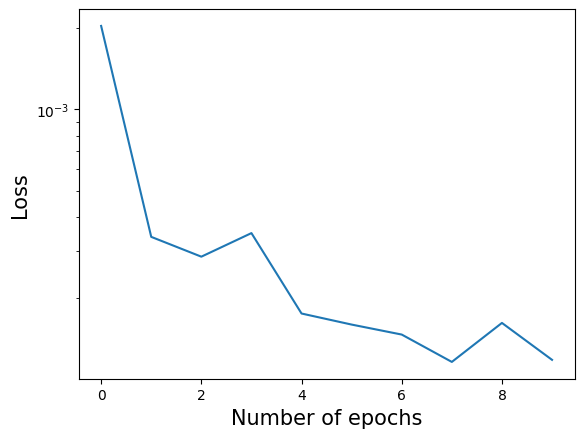

In [ ]:
# Here we plot the training loss after each epoch. It seems that with batches of 100 data, the second epoch solves the problem.
plt.semilogy(losses)
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.show()


In [ ]:
correct = 0
total = 0

with torch.no_grad():                               # This is optional. Since we're not training, we don't need
                                                    # to calculate the gradients for our outputs
  for data in testloader:                           # This is a way to iterate the loader
    images, labels = data
    labels=convert(labels)                          # We convert the labels to 0 and 1
    outputs = net(images)                           # Compute the outputs for a test batch
    predicted = torch.round(outputs.data)           # If the output is higher than 0.5, the prediction is 1.
    total += labels.size(0)                         # This is to count the total number of data
    correct += (predicted.T == labels).sum().item() # This counts the total number of correct predictions
                                                    # Notice that we need to transpose the predictions.
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 98 %


In [ ]:
print(predicted.T-labels)
print(convert(labels))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., -1.]])
tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])


The data loader is an iterable object. To do that, we need to construct an iterator of the object with function `iter()`.
To pull a batch of data we can use method `.next()` as shown below. To iterate in a `for` loop, just use function `enumerate(object)`, where `object` is anything that supports iteration:

`for i, data in enumerate(trainloader):`

Below we show some examples.


In [ ]:
# Get a batch and compute a prediction

dataiter = iter(testloader)                        # Create the iteration
images,labels=dataiter.__next__()                  # Iterate once
labels=convert(labels)
outputs = net(images)                              # Do a prediction with the data
predicted = torch.round(outputs.data)
print("This is the prediction with the first batch:")
print(predicted.int().T)
print("This is the difference between the prediction and the labels of the first batch:")
print(predicted.T-labels)

This is the prediction with the first batch:
tensor([[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
         0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]], dtype=torch.int32)
This is the difference between the prediction and the labels of the first batch:
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


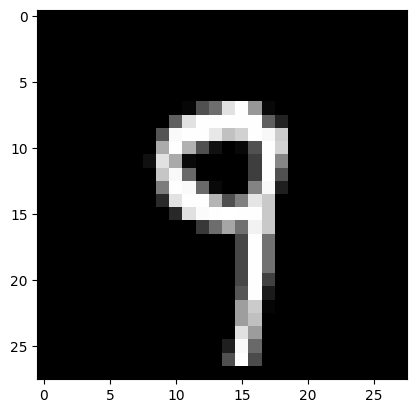

In [ ]:
# Showing an image. If you click on run several times, you will see different images
dataiter = iter(testloader)
x,y=dataiter.__next__()
x = x / 2 + 0.5 # Unnormalize
plt.imshow(x[0,0,:,:],cmap='gray')
plt.show()

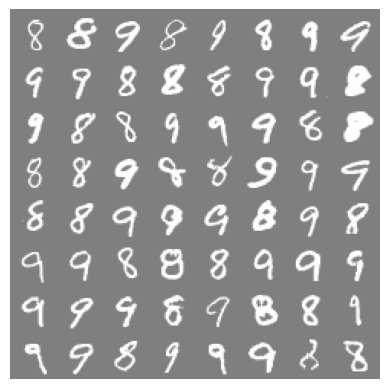

In [ ]:
# Get some random test images
def imshow(img):            # This is a script to show a grid of images
    img = img / 2 + 0.5     # Unnormalize the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.__next__()
# show images
imshow(torchvision.utils.make_grid(images))
plt.show()